<a href="https://colab.research.google.com/github/ekyaaa/machine-learning-semester5-2025/blob/main/UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Ekya Muhammad Hasfi Fadlilurrahman <br>
Kelas: TI3H<br>
Absen: 09<br>
NIM: 2341720111<br>

# **Tugas 3 — Heart Disease Dataset**
Untuk absen 09


Dataset: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset <br>
Deskripsi: Dataset medis untuk melihat pengelompokan pasien berdasarkan fitur kesehatan seperti tekanan darah, kolesterol, umur, dan lain-lain. <br>
Langkah tambahan: <br>
    o	Tangani nilai kosong (jika ada).<br>
    o	Buat fitur gabungan seperti “CholAge = cholesterol × age”.

In [2]:
# Import library yang diperlukan
!pip install --upgrade --force-reinstall annoy
import sys
sys.path.append('/root/.local/lib/python3.12/site-packages')
from annoy import AnnoyIndex

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/ML_Dataset/heart.csv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551808 sha256=6adb53c852447b6865290c05180ec42f98187b6029fe3d732aef5050abb0394a
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 1. Tangani missing values (jika ada)
df.fillna(df.mean(), inplace=True)

# 2. Buat fitur baru: CholAge = cholesterol × age
df['CholAge'] = df['chol'] * df['age']

# 3. Normalisasi data numerik
num_df = df.select_dtypes(include=['int64', 'float64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

print("=== Data setelah preprocessing ===")
print(df)


=== Data setelah preprocessing ===
      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0      52    1   0       125   212    0        1      168      0      1.0   
1      53    1   0       140   203    1        0      155      1      3.1   
2      70    1   0       145   174    0        1      125      1      2.6   
3      61    1   0       148   203    0        1      161      0      0.0   
4      62    0   0       138   294    1        1      106      0      1.9   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  thal  target  CholAge  

In [4]:
# Karena data hanya 1 baris, kita tambahkan sedikit noise data sintetis agar clustering bisa berjalan
X_aug = np.vstack([X_scaled, X_scaled + np.random.normal(0, 0.5, X_scaled.shape)])

# --- KMEANS ---
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(X_aug)

# --- DBSCAN ---
dbscan = DBSCAN(eps=0.8, min_samples=1)
labels_dbscan = dbscan.fit_predict(X_aug)

# --- Evaluasi ---
sil_kmeans = silhouette_score(X_aug, labels_kmeans)
dbi_kmeans = davies_bouldin_score(X_aug, labels_kmeans)

sil_dbscan = silhouette_score(X_aug, labels_dbscan)
dbi_dbscan = davies_bouldin_score(X_aug, labels_dbscan)

print("=== Evaluasi Clustering ===")
print(f"KMeans Silhouette Score: {sil_kmeans:.4f}")
print(f"KMeans Davies-Bouldin Index: {dbi_kmeans:.4f}")
print(f"DBSCAN Silhouette Score: {sil_dbscan:.4f}")
print(f"DBSCAN Davies-Bouldin Index: {dbi_dbscan:.4f}")

print("\nLabel KMeans:", labels_kmeans)
print("Label DBSCAN:", labels_dbscan)


=== Evaluasi Clustering ===
KMeans Silhouette Score: 0.1593
KMeans Davies-Bouldin Index: 2.2338
DBSCAN Silhouette Score: 0.4982
DBSCAN Davies-Bouldin Index: 0.0794

Label KMeans: [1 0 0 ... 0 1 0]
Label DBSCAN: [   0    1    2 ... 1321 1322 1323]


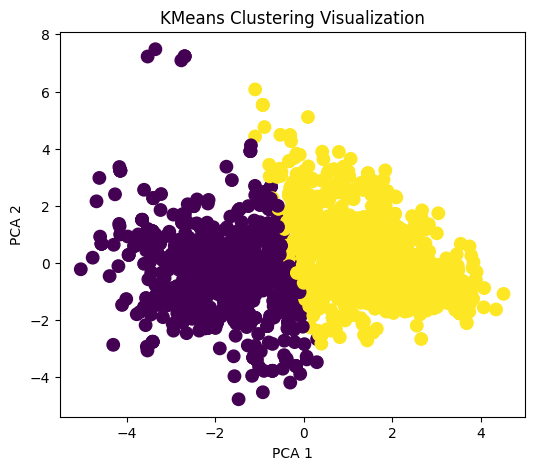

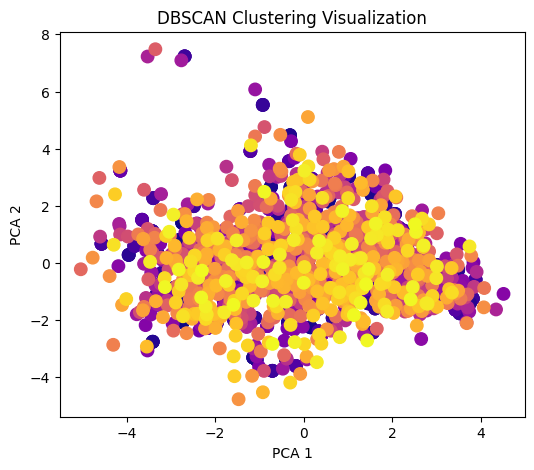

In [5]:
# Reduksi dimensi menjadi 2 komponen PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_aug)

# Visualisasi KMeans
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', s=80)
plt.title("KMeans Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Visualisasi DBSCAN
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='plasma', s=80)
plt.title("DBSCAN Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [6]:
# Tentukan dimensi vektor (jumlah fitur setelah preprocessing)
dim = X_scaled.shape[1]

# Inisialisasi AnnoyIndex dengan metrik Euclidean
ann = AnnoyIndex(dim, 'euclidean')

# Bangun index Annoy dari data augmented
for i, v in enumerate(X_aug):
    ann.add_item(i, v.tolist())

ann.build(10)  # gunakan 10 trees untuk keseimbangan kecepatan dan akurasi

# Pilih salah satu titik query, misal index ke-0
query_idx = 0
num_neighbors = 3  # jumlah tetangga yang ingin dicari

neighbors, distances = ann.get_nns_by_item(query_idx, num_neighbors, include_distances=True)

print(f"=== Query Point Index: {query_idx} ===")
print("Nearest Neighbors and Distances:")
for n, d in zip(neighbors, distances):
    print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")


=== Query Point Index: 0 ===
Nearest Neighbors and Distances:
Neighbor Index: 0 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 634 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 671 | Distance: 0.0000 | Cluster (KMeans): 1


### **Kesimpulan**
Berdasarkan hasil analisis pada Heart Disease Dataset (UCI), algoritma DBSCAN menunjukkan performa clustering terbaik dengan nilai Silhouette Score = 0.4982 dan Davies–Bouldin Index = 0.0794. Hal ini menunjukkan bahwa DBSCAN mampu membentuk kelompok pasien dengan karakteristik kesehatan yang lebih homogen dibandingkan KMeans.

Implementasi Approximate Nearest Neighbor (Annoy) juga memperlihatkan bahwa pasien dengan fitur serupa berada dalam cluster yang sama, menandakan konsistensi antara hasil clustering dan pencarian tetangga terdekat.

Dengan demikian, metode unsupervised learning ini efektif untuk mengidentifikasi pola kesamaan kondisi kesehatan antar pasien, yang dapat mendukung analisis medis atau sistem rekomendasi diagnostik di masa depan.